In [1]:
from fastai.vision.all import *
import pandas as pd
import cam
import util

In [2]:
dls, labels = util.chexpert_data_loader()

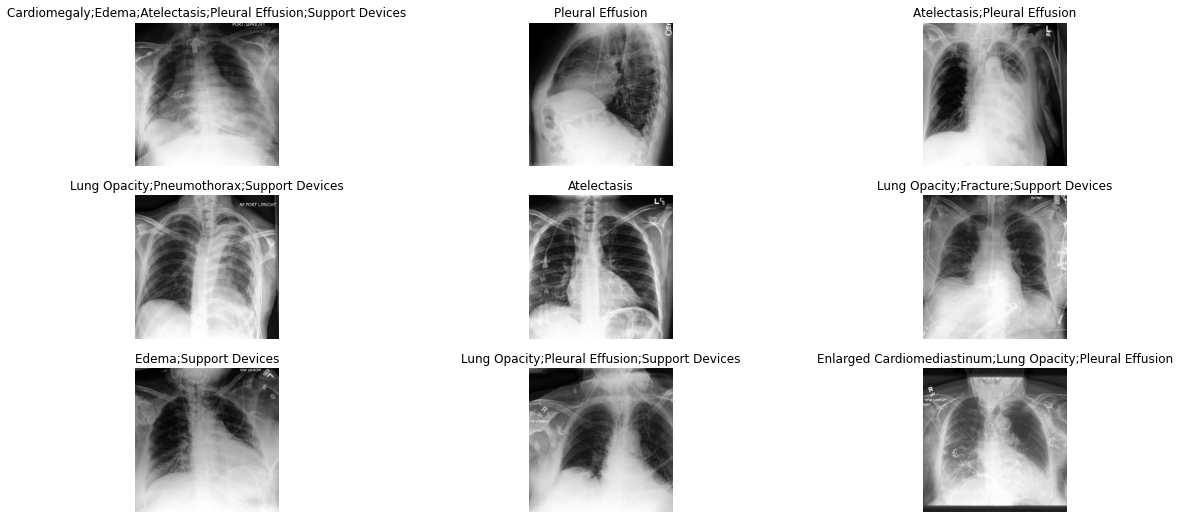

In [3]:
dls.show_batch(max_n=9, figsize=(20,9))

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.370410,0.363942,[0.57617001 0.8261446 0.92458877 0.74495765 0.95332032 0.78436877 0.8734106 0.98413581 0.94140879 0.65365036 0.83601102 0.60666875 0.71814082 0.5477094 ],0.779855,05:59


Better model found at epoch 0 with valid_loss value: 0.3639419674873352.


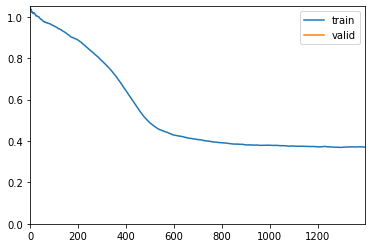

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.361840,0.360191,[0.41496811 0.84286358 0.93467906 0.76244113 0.95878768 0.79638164 0.88741139 0.9867945 0.94601906 0.67195692 0.85219918 0.6194213 0.81502656 0.58205269],0.786380,07:30
1,0.358736,0.357075,[0.45284004 0.85053229 0.93823755 0.76801084 0.91861049 0.8066347 0.89345207 0.98653056 0.94883034 0.681115 0.86033777 0.51955418 0.80433664 0.59073927],0.781935,07:29
2,0.358614,0.355427,[0.40676291 0.85408734 0.93924635 0.77056764 0.95958945 0.81015352 0.89458255 0.98598297 0.9380167 0.68892174 0.86239302 0.52101227 0.83386054 0.62323017],0.786868,07:30
3,0.356210,0.355162,[0.44358132 0.85627017 0.94043845 0.77417708 0.95313494 0.81117364 0.89637171 0.98597288 0.94521921 0.69256536 0.86463671 0.53938645 0.8290453 0.61269671],0.791119,07:31
4,0.353442,0.355093,[0.39436223 0.85601945 0.93861437 0.77151907 0.96081174 0.81523571 0.89751884 0.98689573 0.94545655 0.69375898 0.86496238 0.49588782 0.81800468 0.62994045],0.785100,07:31
5,0.349976,0.356698,[0.4204877 0.85355569 0.93576957 0.7684881 0.95891958 0.80964769 0.89417775 0.98536852 0.94812136 0.68607727 0.85913973 0.69595813 0.82556088 0.63164838],0.801389,07:34
6,0.345594,0.357425,[0.40782314 0.85205778 0.93687492 0.77066355 0.95844759 0.80998795 0.88976374 0.98575562 0.94206754 0.68216112 0.85257104 0.63734626 0.82118808 0.63814212],0.794719,07:32
7,0.338662,0.361112,[0.40916314 0.84721078 0.93393324 0.76945932 0.95511468 0.80423707 0.88846274 0.98513107 0.9462715 0.66786222 0.8458327 0.62286153 0.79498008 0.64248401],0.789626,07:31
8,0.336410,0.362075,[0.4257555 0.84339517 0.93345927 0.76905382 0.95819475 0.80203623 0.88401875 0.98571 0.94361522 0.66825222 0.84306638 0.65134242 0.81367646 0.64321127],0.793777,07:32
9,0.333345,0.363689,[0.42903691 0.8400548 0.9325044 0.76849872 0.95790352 0.80099958 0.88357296 0.98564666 0.94403973 0.66529849 0.84140141 0.64984444 0.8135869 0.64106374],0.793025,07:33


Better model found at epoch 0 with valid_loss value: 0.360191285610199.


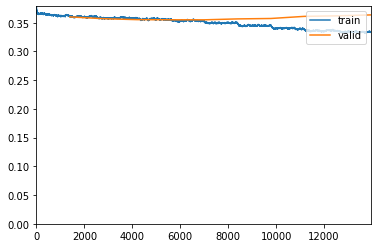

Better model found at epoch 1 with valid_loss value: 0.3570746183395386.
Better model found at epoch 2 with valid_loss value: 0.35542717576026917.
Better model found at epoch 3 with valid_loss value: 0.35516154766082764.
Better model found at epoch 4 with valid_loss value: 0.35509300231933594.
Epoch 5: reducing lr to 6.11420930250719e-05
Epoch 6: reducing lr to 3.8890233730958736e-05
Epoch 7: reducing lr to 1.88388822229883e-05
Epoch 8: reducing lr to 4.95947969306723e-06
Epoch 9: reducing lr to 1.0025812506586629e-09


In [4]:
# First train on conditional probabilities
chexpert_learner_conditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels), y_range=(0, 1),
                                        loss_func=util.BCEFlatHLCP(hierarchy_map=util.hierarchy_map),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])
chexpert_learner_conditional.learn_model(use_saved=False , epochs=10, freeze_epochs=1)

-------Running unconditional-------


epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.358915,0.366949,[0.3984467 0.85540915 0.78112207 0.77221095 0.71968343 0.74756814 0.86231289 0.73564636 0.64452443 0.69406107 0.8630449 0.61772143 0.83332038 0.6477847 ],0.723075,05:44
1,0.358879,0.367183,[0.37858972 0.85509785 0.77904848 0.77233245 0.71485422 0.74651239 0.86127871 0.7377644 0.64328192 0.694045 0.8611302 0.62966846 0.82882446 0.64823489],0.721438,05:43
2,0.358304,0.368257,[0.39769422 0.85396155 0.7783483 0.77204865 0.70710609 0.74488406 0.85886741 0.73646934 0.64832722 0.68923496 0.85888416 0.65213882 0.81377653 0.64959217],0.722425,05:45
3,0.359621,0.368662,[0.39119654 0.8534184 0.78244307 0.77256817 0.73864387 0.74500124 0.85972365 0.73597462 0.61486764 0.68724587 0.85945775 0.58472173 0.8050376 0.654046 ],0.716582,05:50
4,0.358343,0.369053,[0.39489201 0.85108216 0.78120528 0.76984888 0.68203099 0.74143119 0.85667641 0.72796783 0.59779857 0.68341426 0.85726594 0.58152458 0.81045176 0.63637308],0.708278,05:46
5,0.358191,0.369469,[0.40307035 0.85191987 0.77909551 0.76877153 0.72902943 0.74154793 0.85763498 0.74436977 0.64064418 0.68264435 0.85577221 0.57387866 0.77490949 0.63541255],0.713364,05:45
6,0.358991,0.369155,[0.38804942 0.84917835 0.77447992 0.76825863 0.73573721 0.7387762 0.85730782 0.73072928 0.65288082 0.67901534 0.85499401 0.66856615 0.82501489 0.62468985],0.721773,05:46
7,0.359205,0.368991,[0.41851877 0.85090832 0.77917315 0.76998565 0.6907599 0.74282525 0.85584834 0.72589875 0.59398332 0.6832172 0.85594963 0.61405352 0.80991373 0.647296 ],0.713331,05:46
8,0.356966,0.369166,[0.38893462 0.84998862 0.77784263 0.76898219 0.67945865 0.73932882 0.85648233 0.69099848 0.64096179 0.68232656 0.85286436 0.62693659 0.77999266 0.63901724],0.708587,05:51
9,0.357933,0.368824,[0.39534054 0.85133236 0.77760987 0.77025094 0.68229392 0.74092922 0.85709722 0.7174454 0.62847775 0.68498254 0.85520965 0.57503441 0.80915491 0.64811181],0.709881,05:46


Better model found at epoch 0 with valid_loss value: 0.3669486343860626.


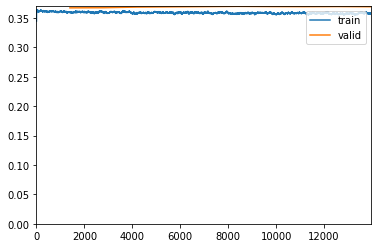

Epoch 1: reducing lr to 2.6681128038123324e-05
Epoch 2: reducing lr to 4.829677826532979e-05
Epoch 3: reducing lr to 7.54748205228601e-05
Epoch 4: reducing lr to 0.00010550132249267124
Epoch 5: reducing lr to 0.00013537792279315239
Epoch 6: reducing lr to 0.0001621211769312186
Epoch 7: reducing lr to 0.00018306058219073185
Epoch 8: reducing lr to 0.0001961051770642056
Epoch 9: reducing lr to 2.7286768085029237e-08


epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.358480,0.368170,[0.39497303 0.85335923 0.77766609 0.76948143 0.68955176 0.74147822 0.86011535 0.71658719 0.63753576 0.68555996 0.8594662 0.57732089 0.80645762 0.64760331],0.711589,07:19
1,0.360961,0.369738,[0.38164999 0.84961821 0.77782354 0.77125303 0.69509337 0.73703528 0.85052897 0.72315532 0.6209605 0.68148477 0.84910641 0.54833846 0.80048236 0.61995621],0.703573,07:19
2,0.360046,0.369816,[0.44946798 0.84743585 0.78050093 0.76782503 0.73110502 0.73322513 0.85063962 0.74082144 0.63599603 0.6803148 0.85107703 0.66827884 0.82719572 0.62583598],0.725084,07:21
3,0.357394,0.370632,[0.40375568 0.84942709 0.77955964 0.76996619 0.7128319 0.73318674 0.85089614 0.72281057 0.63297102 0.67713923 0.84559762 0.5836521 0.81331159 0.64769062],0.712493,07:20
4,0.353795,0.373082,[0.40355491 0.84501299 0.77289737 0.76835085 0.71917212 0.73004147 0.84582075 0.71165387 0.6117845 0.66973319 0.84472691 0.60641073 0.82839227 0.64987392],0.711604,07:19


Better model found at epoch 0 with valid_loss value: 0.3681703805923462.


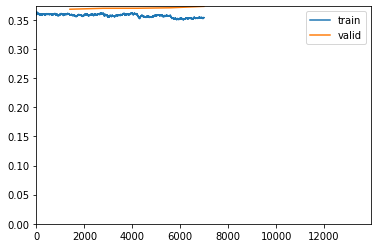

Epoch 1: reducing lr to 7.99740239894999e-05
Epoch 2: reducing lr to 9.999998876272242e-05
Epoch 3: reducing lr to 9.5055461008947e-05
Epoch 4: reducing lr to 8.1187236224085e-05


In [ ]:
# Next train unconditionally for only transfer learning
print('-------Running unconditional-------')
chexpert_learner_unconditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels), y_range=(0, 1),
                                        loss_func=BCELossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, epochs=10, freeze_epochs=10)

In [ ]:
chexpert_learner = chexpert_learner_unconditional
cam.plot_cam(chexpert_learner.learn)